In [ ]:
from pathlib import Path
import os
import pandas as pd

# Possíveis caminhos, em ordem de prioridade
here = Path.cwd()
candidates = [
    Path(os.environ["DATA_FILE"]) if os.environ.get("DATA_FILE") else None,
    Path("../data/paysim.parquet"),
    Path("data/paysim.parquet"),
    here.parent / "data" / "paysim.parquet",
    here / "data" / "paysim.parquet",
]

# Primeiro arquivo existente
DATA_FILE = next((str(p) for p in candidates if p and p.exists()), None)

if not DATA_FILE:
    raise FileNotFoundError(
        "Não encontrei paysim.parquet. "
        "Crie data/paysim.parquet ou defina DATA_FILE apontando para o arquivo."
    )

print("Lendo:", DATA_FILE)
df = pd.read_parquet(DATA_FILE)
print("shape:", df.shape)
print(df.head(3).to_string(index=False))

Lendo: ../data/paysim.parquet
shape: (6, 12)
                 ts  cpf device_id           ip   asn      city  amount currency channel merchant_id beneficiary_id    type
2025-09-01 10:00:00  111      devA 200.100.10.1 AS123  Campinas     120      BRL     app         m01            b01 payment
2025-09-01 10:02:00  111      devA 200.100.10.1 AS123  Campinas     180      BRL     app         m02            b02 payment
2025-09-01 10:03:00  111      devB  177.23.44.9 AS456 São Paulo     300      BRL     web         m03            b03 payment


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA = Path("../datasets")

paysim = pd.read_parquet(DATA / "paysim_sample.parquet")
ccf    = pd.read_parquet(DATA / "credit_card_fraud.parquet")
pep    = pd.read_parquet(DATA / "opensanctions_pep_sample.parquet")

paysim.head(), ccf.head(), pep.head()


(                   ts  cpf device_id            ip      asn       city  \
 0 2025-09-01 10:00:00  111      devA  200.100.10.1    AS123   Campinas   
 1 2025-09-01 10:02:00  111      devA  200.100.10.1    AS123   Campinas   
 2 2025-09-01 11:10:00  333      devD       8.8.8.8  AS15169  São Paulo   
 3 2025-09-01 10:03:00  111      devB   177.23.44.9    AS456  São Paulo   
 4 2025-09-01 10:25:00  111      devC      18.5.6.7    AS789        Rio   
 
    amount currency channel merchant_id beneficiary_id     type  
 0     120      BRL     app         m01            b01  payment  
 1     180      BRL     app         m02            b02  payment  
 2      10      BRL     app         m01            b06  deposit  
 3     300      BRL     web         m03            b03  payment  
 4     700      BRL     web         m04            b05  payment  ,
                    ts card_id  cpf  amount       city channel  is_fraud
 0 2025-09-01 08:00:00    c001  111     120   Campinas     app         0
 1 20

In [2]:
def quick_info(df, name):
    print(f"== {name} ==")
    print("shape:", df.shape)
    print("dtypes:\n", df.dtypes, "\n")
    print("nulls:\n", df.isna().sum(), "\n")

quick_info(paysim, "PaySim")
quick_info(ccf, "Credit Card Fraud")
quick_info(pep, "OpenSanctions (PEP sample)")


== PaySim ==
shape: (6, 12)
dtypes:
 ts                datetime64[ns]
cpf                        int64
device_id                 object
ip                        object
asn                       object
city                      object
amount                     int64
currency                  object
channel                   object
merchant_id               object
beneficiary_id            object
type                      object
dtype: object 

nulls:
 ts                0
cpf               0
device_id         0
ip                0
asn               0
city              0
amount            0
currency          0
channel           0
merchant_id       0
beneficiary_id    0
type              0
dtype: int64 

== Credit Card Fraud ==
shape: (5, 7)
dtypes:
 ts          datetime64[ns]
card_id             object
cpf                  int64
amount               int64
city                object
channel             object
is_fraud             int64
dtype: object 

nulls:
 ts          0
card_id     0


In [6]:
# datetime + sort
for df in [paysim, ccf]:
    if "ts" in df.columns:
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        df.sort_values("ts", inplace=True)

# padroniza textos (evita espaços)
for col in ["cpf", "device_id", "ip", "city", "channel", "beneficiary_id", "merchant_id"]:
    if col in paysim.columns:
        paysim[col] = paysim[col].astype(str).str.strip()

if "cpf" in ccf.columns:
    ccf["cpf"] = ccf["cpf"].astype(str).str.strip()

paysim.head(3)


,ts,cpf,device_id,ip,asn,city,amount,currency,channel,merchant_id,beneficiary_id,type
0,2025-09-01 10:00:00,111,devA,200.100.10.1,AS123,Campinas,120,BRL,app,m01,b01,payment
1,2025-09-01 10:02:00,111,devA,200.100.10.1,AS123,Campinas,180,BRL,app,m02,b02,payment
3,2025-09-01 10:03:00,111,devB,177.23.44.9,AS456,São Paulo,300,BRL,web,m03,b03,payment


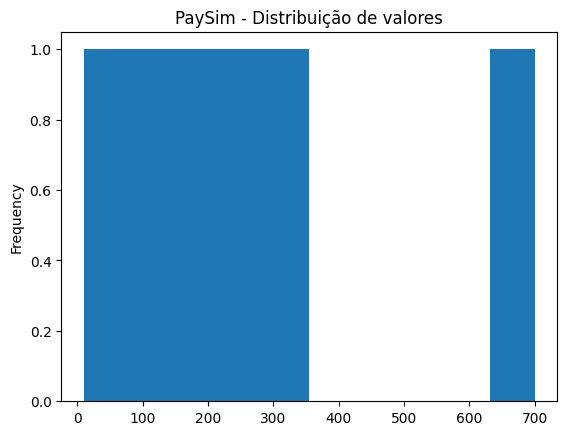

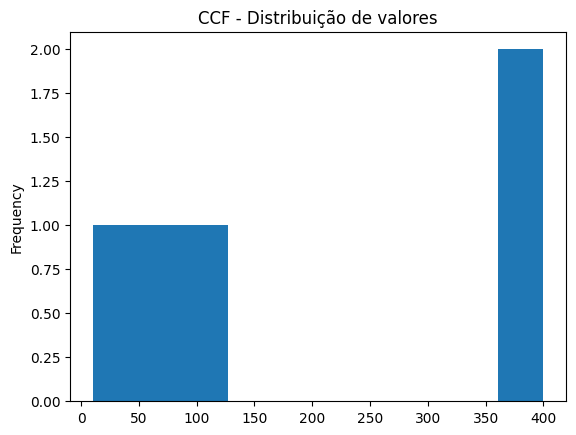

In [7]:
import matplotlib.pyplot as plt

if "amount" in paysim.columns:
    paysim["amount"].plot(kind="hist", bins=10, title="PaySim - Distribuição de valores")
    plt.show()

if "amount" in ccf.columns:
    ccf["amount"].plot(kind="hist", bins=10, title="CCF - Distribuição de valores")
    plt.show()


In [8]:
# Garantias (não faz mal repetir)
assert "ts" in paysim.columns and "cpf" in paysim.columns and "amount" in paysim.columns, "Cols faltando"
paysim["ts"] = pd.to_datetime(paysim["ts"], errors="coerce")
paysim = paysim.sort_values(["cpf","ts"]).reset_index(drop=True)


In [9]:
# Cálculo da contagem de transações em janela móvel de 10 minutos por CPF,
# sem precisar fazer merge depois.
tx_count = (
    paysim
    .groupby("cpf")
    .rolling("10min", on="ts")["amount"]
    .count()
    .reset_index(level=0, drop=True)
)

paysim["tx_count_10min"] = tx_count
paysim[["ts","cpf","amount","tx_count_10min"]].head(10)


,ts,cpf,amount,tx_count_10min
0,2025-09-01 10:00:00,111,120,NaN
1,2025-09-01 10:02:00,111,180,NaN
2,2025-09-01 10:03:00,111,300,NaN
3,2025-09-01 10:25:00,111,700,NaN
4,2025-09-01 10:40:00,111,250,NaN
5,2025-09-01 11:10:00,333,10,NaN


In [10]:
# mapa simples de beneficiário -> nome (mock de cadastro)
bene_map = {"b01":"João Silva","b02":"Loja XPTO","b03":"Maria Souza","b04":"Empresa ABC","b05":"Serviço Z","b06":"Fulano Teste"}

if "beneficiary_id" in paysim.columns:
    paysim["beneficiary_name"] = paysim["beneficiary_id"].map(bene_map).fillna("UNKNOWN")
    alertas_pep = paysim.merge(pep, left_on="beneficiary_name", right_on="name", how="left", indicator=True)

    # pequena amostra dos matches (se houver)
    display(alertas_pep.loc[alertas_pep["_merge"]=="both", 
                            ["ts","cpf","beneficiary_id","beneficiary_name","source_list"]].head(10))


,ts,cpf,beneficiary_id,beneficiary_name,source_list
0,2025-09-01 10:00:00,111,b01,João Silva,PEP_BR_SAMPLE
2,2025-09-01 10:03:00,111,b03,Maria Souza,PEP_BR_SAMPLE


In [11]:
# IMPORTS e caminhos
import pandas as pd
import numpy as np
from pathlib import Path

# Confere diretório atual do notebook (deve ser .../blue-team-aml-portfolio/pandas)
import os
print("CWD:", os.getcwd())

DATA = Path("../datasets")
assert DATA.exists(), f"Pasta {DATA} não encontrada. Verifique caminho."

# Carregar datasets (Parquet gerados no Dia 2)
paysim = pd.read_parquet(DATA / "paysim_sample.parquet")
ccf    = pd.read_parquet(DATA / "credit_card_fraud.parquet")
pep    = pd.read_parquet(DATA / "opensanctions_pep_sample.parquet")

print("OK: datasets carregados")
paysim.head(2), ccf.head(2), pep.head(2)


CWD: /workspaces/case02-reveal-dfir-volatility3-aml/notebooks
OK: datasets carregados


(                   ts  cpf device_id            ip    asn      city  amount  \
 0 2025-09-01 10:00:00  111      devA  200.100.10.1  AS123  Campinas     120   
 1 2025-09-01 10:02:00  111      devA  200.100.10.1  AS123  Campinas     180   
 
   currency channel merchant_id beneficiary_id     type  
 0      BRL     app         m01            b01  payment  
 1      BRL     app         m02            b02  payment  ,
                    ts card_id  cpf  amount       city channel  is_fraud
 0 2025-09-01 08:00:00    c001  111     120   Campinas     app         0
 1 2025-09-01 08:07:00    c001  111     400  São Paulo     web         1,
           name    doc_id country    source_list
 0   João Silva  pep-0001      BR  PEP_BR_SAMPLE
 1  Maria Souza  pep-0002      BR  PEP_BR_SAMPLE)

In [15]:
# mapa simples de beneficiário -> nome (mock de cadastro)
bene_map = {
    "b01":"João Silva","b02":"Loja XPTO","b03":"Maria Souza",
    "b04":"Empresa ABC","b05":"Serviço Z","b06":"Fulano Teste"
}

assert "beneficiary_id" in paysim.columns, "Coluna 'beneficiary_id' não existe em paysim"

paysim["beneficiary_name"] = paysim["beneficiary_id"].map(bene_map).fillna("UNKNOWN")

# Match por nome com PEP (atenção: em produção, normalizar nomes, acentos, etc.)
alertas_pep = paysim.merge(
    pep, left_on="beneficiary_name", right_on="name",
    how="left", indicator=True
)

print("Linhas com match PEP:", (alertas_pep["_merge"]=="both").sum())
display(
    alertas_pep.loc[alertas_pep["_merge"]=="both",
                    ["ts","cpf","beneficiary_id","beneficiary_name","source_list"]].head(10)
)


Linhas com match PEP: 2


,ts,cpf,beneficiary_id,beneficiary_name,source_list
0,2025-09-01 10:00:00,111,b01,João Silva,PEP_BR_SAMPLE
3,2025-09-01 10:03:00,111,b03,Maria Souza,PEP_BR_SAMPLE


In [16]:
from pathlib import Path
Path("../reports/eda").mkdir(parents=True, exist_ok=True)

# salva as linhas com match (se houver)
(alertas_pep.loc[alertas_pep["_merge"]=="both",
                 ["ts","cpf","beneficiary_id","beneficiary_name","source_list"]]
 .to_csv("../reports/eda/pep_matches_sample.csv", index=False))

print("OK: evidências salvas em reports/eda/pep_matches_sample.csv")


OK: evidências salvas em reports/eda/pep_matches_sample.csv


In [17]:
# D5-FINDER (robusto): prioriza Parquet já versionados; só cai em DEMO se não achar nada
import os
from pathlib import Path
import pandas as pd
import numpy as np

print("CWD (Jupyter):", os.getcwd())

DATA = Path("../data") if (Path.cwd().name in {"notebooks","pandas"}) else Path("data")
DATASETS = Path("../datasets") if (Path.cwd().name in {"notebooks","pandas"}) else Path("datasets")

# 1) Tentar Parquet prontos (reprodutibilidade)
parquet_candidates = [
    DATA / "paysim.parquet",
    DATA / "paysim_sample.parquet",
    DATASETS / "paysim.parquet",
    DATASETS / "paysim_sample.parquet",
]

src = None
for p in parquet_candidates:
    if p.exists():
        src = p
        break

if src is not None and src.suffix.lower()==".parquet":
    print("[OK] Fonte encontrada (parquet):", src)
    df = pd.read_parquet(src)
else:
    # 2) Se não houver Parquet, tentar CSV “raw_data” (opcional)
    try_paths = [
        Path("raw_data/paysim/transactions.csv"),
        Path("../raw_data/paysim/transactions.csv"),
        Path("../../raw_data/paysim/transactions.csv"),
        Path("raw_data/synthetic/credit_card_fraud.csv"),
        Path("../raw_data/synthetic/credit_card_fraud.csv"),
        Path("../../raw_data/synthetic/credit_card_fraud.csv"),
    ]
    for p in try_paths:
        if p.exists():
            src = p
            break

    if src is not None and src.suffix.lower()==".csv":
        print("[OK] Fonte encontrada (csv):", src)
        df = pd.read_csv(src)
    else:
        # 3) Fallback final: DEMO mínimo (para não quebrar a primeira execução)
        print("[WARN] Nenhum arquivo encontrado; gerando DEMO dataset…")
        df = pd.DataFrame([
          {"ts":"2025-09-01 10:00:00","cpf":111,"device_id":"devA","ip":"200.100.10.1","asn":"AS123","city":"Campinas","amount":120,"currency":"BRL","channel":"app","merchant_id":"m01","beneficiary_id":"b01","type":"payment"},
          {"ts":"2025-09-01 10:02:00","cpf":111,"device_id":"devA","ip":"200.100.10.1","asn":"AS123","city":"Campinas","amount":180,"currency":"BRL","channel":"app","merchant_id":"m02","beneficiary_id":"b02","type":"payment"},
          {"ts":"2025-09-01 10:03:00","cpf":111,"device_id":"devB","ip":"177.23.44.9","asn":"AS456","city":"São Paulo","amount":300,"currency":"BRL","channel":"web","merchant_id":"m03","beneficiary_id":"b03","type":"payment"},
          {"ts":"2025-09-01 10:20:00","cpf":111,"device_id":"devC","ip":"177.23.44.9","asn":"AS456","city":"São Paulo","amount":700,"currency":"BRL","channel":"web","merchant_id":"m04","beneficiary_id":"b05","type":"payment"},
          {"ts":"2025-09-01 11:10:00","cpf":333,"device_id":"devD","ip":"8.8.8.8","asn":"AS15169","city":"São Paulo","amount":10,"currency":"BRL","channel":"app","merchant_id":"m01","beneficiary_id":"b06","type":"deposit"},
          {"ts":"2025-09-01 12:00:00","cpf":222,"device_id":"devE","ip":"1.1.1.1","asn":"AS13335","city":"Rio","amount":50,"currency":"BRL","channel":"app","merchant_id":"m02","beneficiary_id":"b07","type":"payment"},
        ])
        df["ts"] = pd.to_datetime(df["ts"])

# Normalização mínima de colunas (garante compatibilidade com regras)
cols_lower = {c.lower(): c for c in df.columns}
def pick(*cands):
    for c in cands:
        if c in cols_lower: 
            return cols_lower[c]
    return None

rename_map = {}
m = {
    "ts": ("ts","timestamp","time","datetime","date","event_time"),
    "cpf": ("cpf","customer_id","account_id","user_id","client_id","id_cliente"),
    "amount": ("amount","valor","value","amt","transaction_amount"),
    "device_id": ("device_id","device","deviceid"),
    "ip": ("ip","ip_address","src_ip","ip_src","ipaddr"),
    "channel": ("channel","canal","source_channel","orig_channel"),
    "beneficiary_id": ("beneficiary_id","beneficiary","dest_id","payee_id","merchant_id","counterparty"),
}
for std, cands in m.items():
    found = pick(*cands)
    if found and found != std:
        rename_map[found] = std
df = df.rename(columns=rename_map)

if "ts" in df.columns:
    df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
if "amount" in df.columns:
    df["amount"] = pd.to_numeric(df["amount"], errors="coerce")

need = ["ts","cpf","amount","device_id","ip","channel","beneficiary_id"]
missing = [c for c in need if c not in df.columns]
for c in missing:
    if c == "ts":
        df["ts"] = pd.date_range("2024-07-15 04:00:00", periods=len(df), freq="min")
    elif c == "cpf":
        df["cpf"] = np.arange(len(df)).astype(int)
    elif c == "amount":
        df["amount"] = 0.0
    elif c == "device_id":
        df["device_id"] = "unknown_dev"
    elif c == "ip":
        df["ip"] = "192.168.0.1"
    elif c == "channel":
        df["channel"] = "unknown"
    elif c == "beneficiary_id":
        df["beneficiary_id"] = "b00"

print("Colunas finais:", list(df.columns))
print("Criadas nesta etapa:", missing)

# Salvar padrão e amostra (para as próximas células)
DATA.mkdir(parents=True, exist_ok=True)
outp = DATA / "paysim.parquet"
df.sort_values("ts").to_parquet(outp, index=False)
print(f"[OK] salvo: {outp}")

sample_path = DATASETS / "paysim_sample.parquet"
DATASETS.mkdir(parents=True, exist_ok=True)
df.sample(min(6, len(df)), random_state=42).to_parquet(sample_path, index=False)
print(f"[OK] amostra: {sample_path}")

df.head(3)


CWD (Jupyter): /workspaces/case02-reveal-dfir-volatility3-aml/notebooks
[OK] Fonte encontrada (parquet): ../data/paysim.parquet
Colunas finais: ['ts', 'cpf', 'device_id', 'ip', 'asn', 'city', 'amount', 'currency', 'channel', 'merchant_id', 'beneficiary_id', 'type']
Criadas nesta etapa: []
[OK] salvo: ../data/paysim.parquet
[OK] amostra: ../datasets/paysim_sample.parquet


,ts,cpf,device_id,ip,asn,city,amount,currency,channel,merchant_id,beneficiary_id,type
0,2025-09-01 10:00:00,111,devA,200.100.10.1,AS123,Campinas,120,BRL,app,m01,b01,payment
1,2025-09-01 10:02:00,111,devA,200.100.10.1,AS123,Campinas,180,BRL,app,m02,b02,payment
2,2025-09-01 10:03:00,111,devB,177.23.44.9,AS456,São Paulo,300,BRL,web,m03,b03,payment


In [18]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA = Path("../data") if (Path.cwd().name in {"notebooks","pandas"}) else Path("data")
DATASETS = Path("../datasets") if (Path.cwd().name in {"notebooks","pandas"}) else Path("datasets")

# Carregar cada conjunto com seu nome
paysim = pd.read_parquet(DATA / "paysim.parquet")
ccf    = pd.read_parquet(DATASETS / "credit_card_fraud.parquet")
pep    = pd.read_parquet(DATASETS / "opensanctions_pep_sample.parquet")

def quick_info(df, name):
    print(f"== {name} ==")
    display(df.dtypes)
    print(df.isna().sum(), "\n")
    if "ts" in df.columns:
        print("Faixa ts:", df["ts"].min(), "→", df["ts"].max())
    cols_expect = ["ts","cpf","amount","device_id","ip","channel","beneficiary_id"]
    print("Colunas faltantes:", [c for c in cols_expect if c not in df.columns], "\n")

# Agora inspecione cada um separadamente
quick_info(paysim, "PaySim")
quick_info(ccf, "Credit Card Fraud")
quick_info(pep, "OpenSanctions (PEP sample)")


== PaySim ==


ts                datetime64[ns]
cpf                        int64
device_id                 object
ip                        object
asn                       object
city                      object
amount                     int64
currency                  object
channel                   object
merchant_id               object
beneficiary_id            object
type                      object
dtype: object

ts                0
cpf               0
device_id         0
ip                0
asn               0
city              0
amount            0
currency          0
channel           0
merchant_id       0
beneficiary_id    0
type              0
dtype: int64 

Faixa ts: 2025-09-01 10:00:00 → 2025-09-01 10:25:00
Colunas faltantes: [] 

== Credit Card Fraud ==


ts          datetime64[ns]
card_id             object
cpf                  int64
amount               int64
city                object
channel             object
is_fraud             int64
dtype: object

ts          0
card_id     0
cpf         0
amount      0
city        0
channel     0
is_fraud    0
dtype: int64 

Faixa ts: 2025-09-01 08:00:00 → 2025-09-01 12:00:00
Colunas faltantes: ['device_id', 'ip', 'beneficiary_id'] 

== OpenSanctions (PEP sample) ==


name           object
doc_id         object
country        object
source_list    object
dtype: object

name           0
doc_id         0
country        0
source_list    0
dtype: int64 

Colunas faltantes: ['ts', 'cpf', 'amount', 'device_id', 'ip', 'channel', 'beneficiary_id'] 



In [20]:
# [D5-2.3-FIX] Amostra segura + path robusto
from pathlib import Path
import math

# Decide a pasta data conforme o CWD do notebook
CWD = Path.cwd().name
DATA_DIR = Path("../data") if CWD in {"notebooks", "pandas"} else Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

total = len(df)
assert total > 0, "Seu DataFrame está vazio. Verifique o carregamento do paysim.parquet."

n = min(1000, total)
df_sample = df.sample(n, random_state=42) if total > 1000 else df.copy()

outp = DATA_DIR / "paysim_sample.parquet"
df_sample.to_parquet(outp)
print(f"Amostra salva com {len(df_sample)}/{total} linhas em {outp}")
df_sample.head(3)


Amostra salva com 6/6 linhas em ../data/paysim_sample.parquet


,ts,cpf,device_id,ip,asn,city,amount,currency,channel,merchant_id,beneficiary_id,type
0,2025-09-01 10:00:00,111,devA,200.100.10.1,AS123,Campinas,120,BRL,app,m01,b01,payment
1,2025-09-01 10:02:00,111,devA,200.100.10.1,AS123,Campinas,180,BRL,app,m02,b02,payment
2,2025-09-01 10:03:00,111,devB,177.23.44.9,AS456,São Paulo,300,BRL,web,m03,b03,payment
